In [1]:
using ForwardDiff
using Turing
using LimberJack
using CSV
using NPZ
using Plots
using FITSIO
using Plots
using LinearAlgebra
using Distributed
using StatsPlots
using Optim

In [2]:
cosmo = LimberJack.Cosmology(0.3, 0.05, 0.67, 0.96, 0.81, tk_mode="EisHu", Pk_mode="Halofit");

In [8]:
ks = [0.001, 0.01, 0.1, 1.0, 10.0]
data_vector = nonlin_Pk(cosmo, ks, 0.0)
cov_tot = (0.1 .* data_vector) .^ 2
inv_cov = cov_tot .^ -1

5-element Vector{Float64}:
 2.224820962038732e-7
 1.3057997730747509e-8
 7.542407794517566e-7
 0.00013768740229183694
 0.5766592450692247

In [42]:
function get_Xi2(Ωm, s8)
    cosmology = LimberJack.Cosmology(Ωm, 0.05, 0.67, 0.96, s8,
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit")
    
    theory = nonlin_Pk(cosmology, ks, 0.0)
    diff = @.(data_vector-theory)
    Xi2 = dot(diff,inv_cov.*diff)
    return Xi2
end;

In [10]:
@model function model(data_vector::Vector{Float64})
    Ωm ~ Uniform(0.1, 0.6)
    s8 ~ Uniform(0.6, 1.0)
    cosmology = LimberJack.Cosmology(Ωm, 0.05, 0.67, 0.96, s8,
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit")
    theory = nonlin_Pk(cosmology, ks, 0.0)
    data_vector ~ MvNormal(theory, cov_tot)
end;

In [11]:
map_estimate = optimize(model(data_vector), MAP(), NelderMead())

ModeResult with maximized lp of -60.00
2-element Named Vector{Float64}
A   │ 
────┼─────────
:Ωm │ 0.301939
:s8 │ 0.810416

In [29]:
iterations = 3000
nadapts = 500
MH_chain = sample(model(data_vector), MH(), iterations,
                   nadapt=nadapts, progress=true; save_state=true);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:53


In [30]:
describe(MH_chain)[1]

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.3649    0.1309     0.0024    0.0037    928.5754    0.9999    ⋯
          s8    0.8426    0.0787     0.0014    0.0022   1045.4459    1.0007    ⋯
                                                                1 column omitted


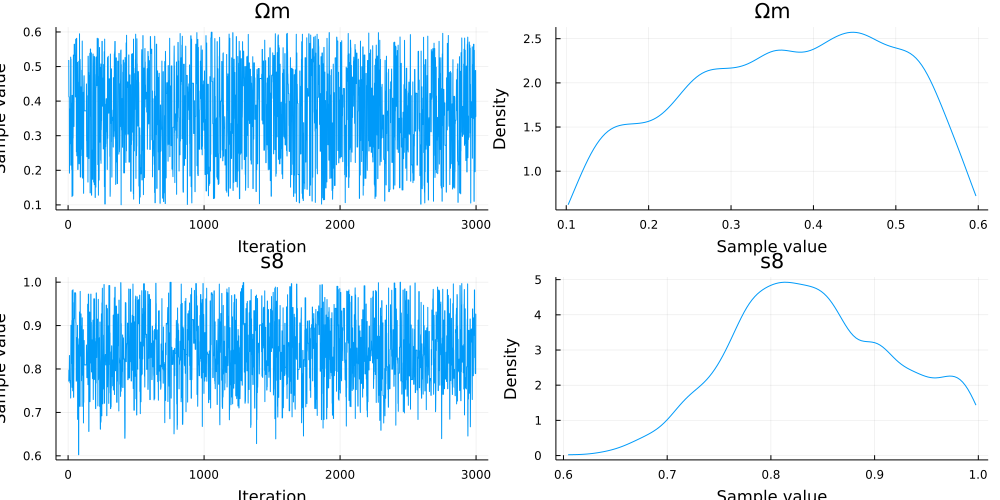

In [31]:
plot(MH_chain)

In [56]:
iterations = 3000
adaptation = 100
TAP = 0.6

NUTS_chain = sample(model(data_vector), NUTS(adaptation, TAP),
            iterations, progress=true; save_state=true)

┌ Info: Found initial step size
│   ϵ = 3.2
└ @ Turing.Inference /home/jaime/.julia/packages/Turing/uMoX1/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/w90s5/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/w90s5/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/w90s5/src/hamiltonian.jl:47
Sampling:   2%|█                                        |  ETA: 0:05:14┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ 

Chains MCMC chain (3000×14×1 Array{Float64, 3}):

Iterations        = 101:1:3100
Number of chains  = 1
Samples per chain = 3000
Wall duration     = 396.27 seconds
Compute duration  = 396.27 seconds
parameters        = Ωm, s8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.3595    0.1348     0.0025    0.0054    577.7626    1.0014    ⋯
          s8    0.8453    0.0794     0.0014    0.0023   1164.2181    0.9999    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

     

In [57]:
describe(NUTS_chain)[1]

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.3595    0.1348     0.0025    0.0054    577.7626    1.0014    ⋯
          s8    0.8453    0.0794     0.0014    0.0023   1164.2181    0.9999    ⋯
                                                                1 column omitted


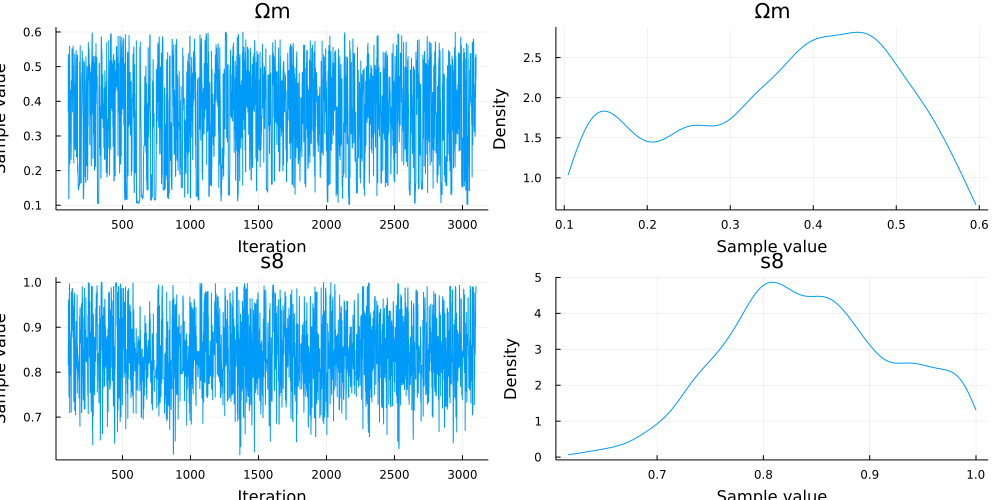

In [58]:
plot(NUTS_chain)

In [59]:
MH_vals = get(MH_chain, [:Ωm, :s8, :lp])

(s8 = [0.7722834058132655; 0.7722834058132655; … ; 0.9265694409673046; 0.9265694409673046;;], lp = [-61.27129690410275; -61.27129690410275; … ; -60.82903094120843; -60.82903094120843;;], Ωm = [0.5174524504457574; 0.5174524504457574; … ; 0.35491736575381816; 0.35491736575381816;;])

In [60]:
NUTS_vals = get(NUTS_chain, [:Ωm, :s8, :lp])

(s8 = [0.8151749893290591; 0.8588256611008772; … ; 0.9772190550178205; 0.9910587696040831;;], lp = [-64.42395946015276; -65.92960541079177; … ; -66.21267256032733; -67.79357045374019;;], Ωm = [0.37060684993175463; 0.5348423458810053; … ; 0.465947827295212; 0.5363860028325931;;])

In [61]:
Wms = LinRange(0.1, 0.6, 40)
s8s = LinRange(0.6, 1.0, 40)

40-element LinRange{Float64, Int64}:
 0.6,0.610256,0.620513,0.630769,0.641026,…,0.969231,0.979487,0.989744,1.0

In [62]:
Xi2s = [get_Xi2(Wm, s8) for Wm in Wms, s8 in s8s];

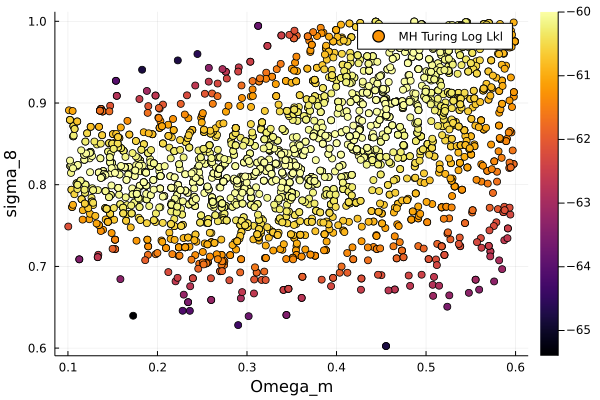

In [63]:
scatter(MH_vals.Ωm, MH_vals.s8, marker_z = MH_vals.lp, label="MH Turing Log Lkl",
        xlabel="Omega_m", ylabel="sigma_8")

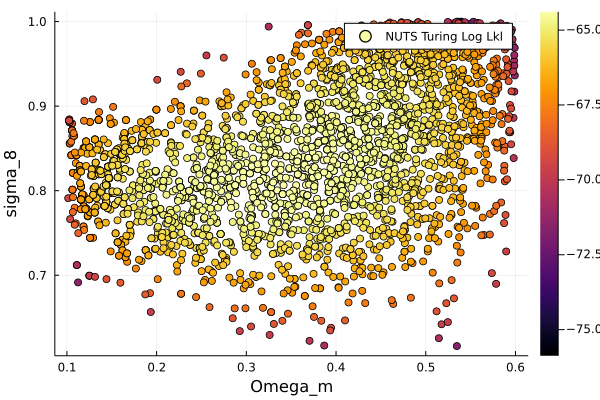

In [69]:
scatter(NUTS_vals.Ωm, NUTS_vals.s8, marker_z = NUTS_vals.lp, label="NUTS Turing Log Lkl",
        xlabel="Omega_m", ylabel="sigma_8")

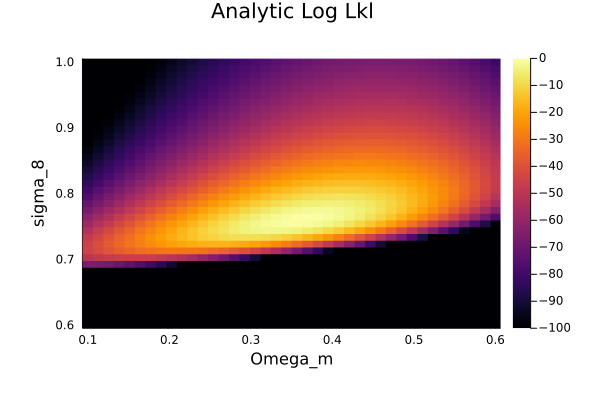

In [67]:
using Plots.PlotMeasures
heatmap(Wms, s8s, @.(-0.5 * Xi2s), clim=(-100, 0), title="Analytic Log Lkl",
    xlabel="Omega_m", ylabel="sigma_8", margin=8mm)